In [1]:
%matplotlib inline

from itertools import combinations
import os
import sys

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from scipy.stats import spearmanr

pd.set_option("display.max_columns", 101)
pd.set_option("display.float_format", lambda x: "%.2f" % x )

# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src', 'data')
sys.path.append(src_dir)

# import my method from the source code
%aimport utils

# load environment varibles
from dotenv import find_dotenv, load_dotenv
load_dotenv(find_dotenv())

pass

/Users/bull/anaconda/envs/farmdrive/lib/python3.5/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Geographic Features

For our first pass at the data, our area of interest is just **Nakuru** county.

In [2]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

engine = create_engine('postgresql://localhost/farmdrive')
session = sessionmaker(bind=engine)()

In [3]:
query = """
SELECT ST_AsGeoJSON(county.geom)
FROM county
WHERE county.county = 'Nakuru';
"""

# Execute the query in the session
result = session.execute(query)
aoi_geojson = result.first()[0]

with open("../data/interim/nakuru.geojson", "w") as gjfile:
    gjfile.write(aoi_geojson)

In [5]:
# individual geojson polygons for each raster pixel
query = """
SELECT
json_build_object(
    'type', 'Feature',
    'id', (poly_pixels.x || '_' || poly_pixels.y),
    'geometry', ST_AsGeoJSON(poly_pixels.geom) :: JSON,
    'properties', json_build_object('maize_yield', poly_pixels.val)
)
FROM
  (SELECT (ST_PixelAsPolygons(ST_Union(ST_Clip("maiz_p--ssa".rast, clipped_geom.geom)))).*
    FROM
      "maiz_p--ssa",
      (SELECT county.geom FROM county WHERE county.county = 'Nakuru') AS clipped_geom
    WHERE ST_Intersects("maiz_p--ssa".rast, clipped_geom.geom)
  ) AS poly_pixels;
"""

# Execute the query in the session
result = session.execute(query)
aoi_raster = result.first()
aoi_raster['json_build_object']


{'geometry': {'coordinates': [[[36.1666784185933, 0.249992908411585],
    [36.2500117633153, 0.249992908411585],
    [36.2500117633153, 0.1666595636896],
    [36.1666784185933, 0.1666595636896],
    [36.1666784185933, 0.249992908411585]]],
  'type': 'Polygon'},
 'id': '11_1',
 'properties': {'maize_yield': 2240},
 'type': 'Feature'}

In [4]:
query = """
SELECT st_astiff(ST_Union(ST_Clip("maiz_p--ssa".rast, clipped_geom.geom)))
  FROM (SELECT county.geom
      FROM county
      WHERE county.county = 'Nakuru') AS clipped_geom,
    "maiz_p--ssa"
  WHERE ST_Intersects("maiz_p--ssa".rast, clipped_geom.geom);
"""

# Execute the query in the session
result = session.execute(query)
aoi_raster = result.first()['st_astiff']

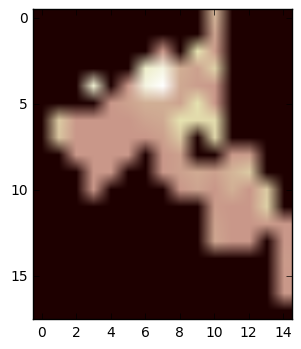

In [6]:
import rasterio

with rasterio.io.MemoryFile(aoi_raster.tobytes()) as memfile:
    with memfile.open() as dataset:
        data_array = dataset.read()
        plt.imshow(data_array[0, :, :], cmap='pink')

In [23]:
import json
aoi = json.loads(aoi_geojson)

In [24]:
from planet import api
planet search \
--aoi_id dJ6L8Yp5wgXpogzy \
-s ortho \
--where image_statistics_image_quality gte standard \
--where acquired gte "2016-07-31T04:00:00.000Z" \
--where acquired lte "2016-09-30T04:00:00.000Z" \
--where cloud_cover.estimated lte 15 \
--where image_statistics.gsd gte 1 \
--where image_statistics.gsd lte 30 \
--where sat.off_nadir lte 62 \
--where published gte "2009-01-01T05:00:00.000Z"

client = api.Client()

filters = {
    'cloud_cover.estimated.lte': 15,
}


body = client.get_scenes_list(aoi_id='dJ6L8Yp5wgXpogzy',
                              intersects=aoi,
                              **filters)

geojson = body.get()

# the results are paginated and the total result set count is provided
print('%s total results' % geojson['count'])

# loop over features and print the scene 'id'
# for f in geojson['features']:
#     print f['id']

APIException: 414: <html>
<head><title>414 Request-URI Too Large</title></head>
<body bgcolor="white">
<center><h1>414 Request-URI Too Large</h1></center>
<hr><center>nginx/1.10.1</center>
</body>
</html>


In [ ]:
from osgeo import gdal

vsicurl_url = '/vsicurl/' + download_url
output_file = item_id + '_subarea.tif'

# GDAL Warp crops the image by our AOI, and saves it
gdal.Warp(output_file, vsicurl_url, dstSRS = 'EPSG:4326', cutlineDSName = 'subarea.geojson', cropToCutline = True)

In [ ]:
def postgis_rater_in_geom(session, rast_table, geom_table, geom_group_id, feature_name=None):
    """ Queries a raster table for all the summary stats within the geoms
        in geom_table and groups results by geom_group_id.
        
        For example, query the trmm_acc_2015 rainfall raster table
        by county with postgis_rater_in_geom(session, 'trmm_acc_2015', 'county', 'county')
        
        Returns: A dataframe with the geom_group_id as the index and the summary
                 stats as the columns.
                 
        This method works for querying a raster with an existing shapefile. (To
        query a shapefile (polygon) instead, see postgis_geom_in_geom_summary).
    """
    
    # If unsupported characters in the table name, make
    # sure to quote it
    if "-" in rast_table:
        rast_table = '"{}"'.format(rast_table)
        
    if "-" in geom_table:
        geom_table = '"{}"'.format(geom_table)

    q_fmt = """
        SELECT {1}.{2}, (stats).*
         FROM {0} 
          INNER JOIN {1}
          ON ST_Intersects({0}.rast, {1}.geom), 
            ST_SummaryStats(ST_Clip({0}.rast, {1}.geom), 1) AS stats
         ORDER BY county.county;
    """
        
    # Execute the query in the session
    result = session.execute(q_fmt.format(rast_table, geom_table, geom_group_id))
    
    if feature_name is None:
        feature_name = rast_table
    
    # Put results into a dataframe
    df_columns = ['{}_{}'.format(geom_table, geom_group_id)] + \
                 ['{}_{}'.format(feature_name, c) for c in ['count', 'sum', 'mean', 'stddev', 'min', 'max']]
    query_df = pd.DataFrame(result.fetchall(),
                            columns=df_columns).set_index('county_county')
    
    # Return all the results
    return query_df

test_res = postgis_rater_in_geom(session, 'aez16_clas--ssa', 'county', 'county', 'agro_eco_zone')
test_res

In [ ]:
def raster_feature_by_county(session, rast_table, feature_name=None):
    """ Aggregates a raster table by county across multiple non-overlapping
        rasters if necessary. For example, our elevation data from SRTM
        has multiple non-overlapping tiles we need to query in order
        to cover every county in Kenya.
    """
    
    # If we need to query data from multiple raster tables, do so
    if isinstance(rast_table, list):
        pixel_dfs = [postgis_rater_in_geom(session, r, 'county', 'county', feature_name=feature_name) \
                         for r in rast_table]
        pixel_df = pd.concat(pixel_dfs).reset_index().groupby('county_county').mean()
    else:
        pixel_df = postgis_rater_in_geom(session, rast_table, 'county', 'county', feature_name=feature_name)
        
    return pixel_df

raster_feature_by_county(session, ['srtm_43_12', 'srtm_43_13', 'srtm_44_12', 'srtm_44_13', 'srtm_45_12', 'srtm_45_13'], feature_name='elevation')

In [ ]:
# all raster features
table_feature_map = {
    "rainfall_2012": "trmm_acc_2012",
    "rainfall_2013": "trmm_acc_2013",
    "rainfall_2014": "trmm_acc_2014",
    "rainfall_2015": "trmm_acc_2015",
    "elevation": ['srtm_43_12', 'srtm_43_13', 'srtm_44_12', 'srtm_44_13', 'srtm_45_12', 'srtm_45_13'],
    "agro_ecological_zone": "aez16_clas--ssa",
}

all_features = []
for col_name, db_table in table_feature_map.items():
    f = raster_feature_by_county(session, db_table, feature_name=col_name)
    all_features.append(f)
    
county_raster_features = pd.concat(all_features, axis=1)

In [ ]:
def postgis_geom_in_geom_summary(session,
                                 value_table,
                                 value_columns,
                                 geom_table,
                                 geom_group_id,
                                 feature_name=None):
    """ Querys `value_table` for summary statistics of each `value_column` aggregated
        by the geom_group_id in the geom_table.
        
        This method works for querying a shapefile with an existing shapefile. (To
        query a raster instead, see postgis_rater_in_geom).
    """

    q_fmt = """
        SELECT
          {1}.{2},

          {3}

        FROM
          {1},
          {0}
        WHERE
          ST_Contains({1}.geom, {0}.geom)
        GROUP BY {1}.{2};
    """
    
    summary_format = """
          AVG({0}.{1}) {1}_avg,
          MIN({0}.{1}) {1}_min,
          MAX({0}.{1}) {1}_max,
          stddev_samp({0}.{1}) {1}_std"""
    
    summaries = ',\n'.join([summary_format.format(value_table, c) for c in value_columns])
    
    q = q_fmt.format(value_table, geom_table, geom_group_id, summaries)
    
    # Execute the query in the session
    result = session.execute(q)
    
    if feature_name is None:
        feature_name = rast_table
    
    # Put results into a dataframe
    df_columns = ['{}_{}'.format(geom_table, geom_group_id)] + \
                 ['{}_{}'.format(f, c) for f in value_columns for c in ['avg', 'min', 'max', 'stddev']]
        
    query_df = pd.DataFrame(result.fetchall(),
                            columns=df_columns).set_index('county_county')
    
    # Return all the results
    return query_df

all_soil_params = [
    'cfrag',
    'sdto',
    'stpc',
    'clpc',
    'bulk',
    'tawc',
    'cecs',
    'bsat',
    'cecc',
    'phaq',
    'tceq',
    'gyps',
    'elco',
    'totc',
    'totn',
    'ecec'
]

all_soil_summary = postgis_geom_in_geom_summary(session,
                                                'soilparameterestimated_t1s1d1',
                                                all_soil_params,
                                                'county',
                                                'county',
                                                feature_name='soil')
all_soil_summary

In [ ]:
county_geo_features = county_raster_features.join(all_soil_summary)
county_geo_features

In [ ]:
# Rename counties to match the ones that we use in our targets.
targets = pd.read_csv("../data/processed/targets-by-county.csv", index_col=0)
county_geo_features.index = utils.resolve_county_names(county_geo_features.index,
                                                       targets.index)

county_geo_features.to_csv("../data/processed/county-geo-features.csv")